In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import PIL.Image as Image
import tensorflow as tf
import numpy as np
import shutil
import glob
import cv2
import os

In [3]:
class VideoToImage:

    def __init__(self,target_dataset_folder):

        self.base_dir = os.path.join(os. getcwd(), target_dataset_folder) 
        self.list_of_videos, self.class_names = self.get_list_videos()

        self.total_train = 0
        self.total_val = 0

        self.make_videos_dirs()  
    

    def get_list_videos(self):
        """ generate list of videos in the current directory to generate the dataset with labels same as the video names """

        list_of_videos =  glob.glob("./*.mp4")
        class_names = list(map(lambda x: x.split('./')[1].split('.')[0], list_of_videos))
        return list_of_videos, class_names



    def make_videos_dirs(self):
        """ create directories for classes """

        try:
            if not os.path.exists(f'{self.base_dir}'):
                os.makedirs(f'{self.base_dir}')
        except OSError:
                print ('Error: Creating directory of data')

        for class_name in self.class_names:
            try:
                if not os.path.exists(f'{self.base_dir}/{class_name}'):
                    os.makedirs(f'{self.base_dir}/{class_name}')
            except OSError:
                print ('Error: Creating directory of data') 
                
    

    def check_images_generation(self):
        """  return True if images have already been generated """

        if not self.list_of_videos:
            print("There is no videos in the given directory")
            return True

        for class_name in self.class_names:
            
            if glob.glob(f"{self.base_dir}/{class_name}/*.jpg") :
                print("Images have already been generated")
                return True

            if glob.glob(f"{self.base_dir}/train/{class_name}/*.jpg"):
                print("Images have been generated and moved to train or val directory")
                return True
        
        return False



    def generate_images(self):
        """ generate list of images from each existing video """

        if self.check_images_generation():
            return

        for index,video in enumerate(self.list_of_videos):
            cam = cv2.VideoCapture(video)
            currentframe = 0
            while(True):
                # reading from frame
                ret,frame = cam.read()
                if ret:
                    name = f'{self.base_dir}/{self.class_names[index]}/{self.class_names[index]}_' + str(currentframe) + '.jpg'
                    print ('Creating...' + name)
                    cv2.imwrite(name, frame)
                    currentframe += 1
                else:
                    break

            cam.release()
            cv2.destroyAllWindows()


    
    def create_train_val_dataset(self):
        """ create folders for train and validation dataset and move images to them  """

        if self.check_images_generation():
            return

        total_train = 0 # total number of training images
        total_val = 0 # total number of validation images

        for cl in self.class_names:
            img_path = os.path.join(self.base_dir, cl)
            images = glob.glob(img_path + '/*.jpg')
            print("{}: {} Images".format(cl, len(images)))
            train, val = images[:round(len(images)*0.8)], images[round(len(images)*0.8):]
            total_train += len(train)
            total_val+=len(val)
            
            for t in train:
                if not os.path.exists(os.path.join(self.base_dir, 'train', cl)):
                    os.makedirs(os.path.join(self.base_dir, 'train', cl))
                shutil.move(t, os.path.join(self.base_dir, 'train', cl))

            for v in val:
                if not os.path.exists(os.path.join(self.base_dir, 'val', cl)):
                    os.makedirs(os.path.join(self.base_dir, 'val', cl))
                shutil.move(v, os.path.join(self.base_dir, 'val', cl))
        
        self.total_train = total_train
        self.total_val = total_val

        return total_train, total_val 


In [33]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from VideoToImage import VideoToImage
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import PIL.Image as Image
import tensorflow as tf
import numpy as np
import glob
import os


class PinClassifier:

    def __init__(self,base_dir):
        self.base_dir = base_dir

        self.train_data_gen = None # train data generator : includes training images dataset
        self.val_data_gen = None # validation data generator : includes validation images dataset

        self.model = None # current Model
        self.history = None # model history

    def load_dataset(self,class_names=[],IMG_SHAPE = (384,384),BATCH_SIZE=32,horizontal_flip=True,zoom_range=0.5,shuffle=True,color_mode="rgb",class_mode="sparse"):

        train_dir = os.path.join(self.base_dir, 'train')
        val_dir = os.path.join(self.base_dir, 'val')
        IMG_SHAPE = (384,384)
        BATCH_SIZE = 32

        if not len(class_names):
            print("Please specify the list of classname")
            return
        
        for class_name in class_names:
            if not len(glob.glob(f"{train_dir}/{class_name}/*.jpg")):
                print("There is no images in train directory, double check generating images to that folder")
                return 
            if not len(glob.glob(f"{val_dir}/{class_name}/*.jpg")):
                print("There is no images in validation directory, double check generating images to that folder")
                return 

        image_train_gen = ImageDataGenerator(rescale=1.0/255,horizontal_flip=True,
                                            #zoom_range=0.5,rotation_range=45,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2
                                            )

        train_data_gen = image_train_gen.flow_from_directory(batch_size=BATCH_SIZE,directory=train_dir,target_size=IMG_SHAPE,shuffle=True,
                                                            class_mode=class_mode, # class_mode is int >> sparse_categorical_crossentropy
                                                            color_mode = color_mode)

        image_val_gen = ImageDataGenerator(rescale=1.0/255,horizontal_flip=True,
                                            #zoom_range=0.5,rotation_range=45,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2
                                            )

        val_data_gen = image_val_gen.flow_from_directory(batch_size=BATCH_SIZE,directory=train_dir,target_size=IMG_SHAPE,shuffle=True,
                                                            class_mode=class_mode, # class_mode is int >> sparse_categorical_crossentropy
                                                            color_mode = color_mode)

        self.train_data_gen = train_data_gen
        self.val_data_gen = val_data_gen

        return train_data_gen, val_data_gen
    

    def plot_samples(self,n=5):
        """ n: number of samples """

        if not self.train_data_gen:
            print("Please load training dataset first, ex: train_data_data_gen")
            return

        augmented_images = [self.train_data_gen[0][0][0] for i in range(n)]

        if not len(augmented_images):
            print("There is no images in training director... Please check loading them first")
        fig, axes = plt.subplots(1, 5, figsize=(20,20))
        axes = axes.flatten()

        for img, ax in zip( augmented_images, axes):
            ax.imshow(img)
        plt.tight_layout()
        plt.show()
    

    def num_train_val_dataset(self,class_names):
        total_train = 0
        total_val = 0
        for i in class_names:
            total_train+=len(os.listdir(os.path.join(self.base_dir,'train',i)))
            total_val+=len(os.listdir(os.path.join(self.base_dir,'val',i))) 
        
        return total_train, total_val
    

    def create_model(self,IMG_SHAPE):
        # custom model
        model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], 3)),
            tf.keras.layers.MaxPooling2D(2, 2),

            tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2,2),

            tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2,2),

            tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2,2),

            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dense(2) # we have 2 categories now
        ])

        self.model = model

        return model
    
    def compile_model(self,model,optimizer='adam',metrics=['accuracy'],label_mode="int"):
        """ label_mode : int >> sparse_categorical_crossentropy loss, 
            label_mode : categorical >> categorical_crossentropy,
            label_mode : binary >> binary_crossentropy
        """
        loss = None
        if label_mode == "int":
            loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) # produces a category index of the most likely matching category.

        elif label_mode == "categorical":
            loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True) # produces a one-hot array containing the probable match for each category

        elif label_mode == "binary":
            loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

        else:
            raise TypeError("Given label mode is wrong. Please check it again")

        model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])
        
        return model.summary()
    

    def train_model(self,model,train_data_gen,val_data_gen,total_train,total_val,BATCH_SIZE,epochs):
        history = model.fit_generator(train_data_gen,
                                steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
                                epochs=epochs,
                                validation_data=val_data_gen,
                                validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))))
        
        self.history = history
        return history
    

    def plot_acc_loss_estimates(self,EPOCHS = 10):
        """ plot the relationship between increasing the number of epochs and the effect on model loss and accuracy """
        EPOCHS = EPOCHS
        # Visualizing training results
        acc = self.history.history['accuracy']
        val_acc = self.history.history['val_accuracy']

        loss = self.history.history['loss']
        val_loss = self.history.history['val_loss']

        epochs_range = range(EPOCHS)

        plt.figure(figsize=(8, 8))
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, label='Training Accuracy')
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')

        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, label='Training Loss')
        plt.plot(epochs_range, val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.savefig('./foo.png')
        plt.show()
    

    def plot_predictions(self,class_names):

        image_batch, _ = next(self.val_data_gen)

        label_batch = class_names

        result_batch = model.predict(image_batch)

        plt.figure(figsize=(10,9))
        for n in range(30):
            plt.subplot(6,5,n+1)
            # plt.subplots_adjust(hspace = 0.3)
            plt.imshow(image_batch[n])
            plt.title(label_batch[np.argmax(np.array(result_batch[n]))])
            plt.axis('off')
        _ = plt.suptitle("Model predictions ")
    

    def save_model(self,model,model_name):
        model.save(f'{model_name}.h5')
    
    def laod_model(self,model_name):
        return tf.keras.models.load_model(f'{model_name}.h5')

    
    

In [39]:
def main(model_name="pin_model.h5",pin_dataset_folder="pin_dataset",IMG_SHAPE = (384,384),BATCH_SIZE = 32,EPOCHS = 2,load_model=False):
    """ generate_images: if True means there is no images and we need to convert videos to images, else >> images already_exist 
        pin_dataset: pin-images main floder name
    """

    if load_model:
        return tf.keras.models.load_model(model_name)

    # 1- generate images from videos
    print()
    print("Start generating images from videos....")

    video_to_images = VideoToImage(pin_dataset_folder)
    video_to_images.generate_images() # generate_images
    video_to_images.create_train_val_dataset() # create train and validation dataset

    
    # 2- initialize the required parameters
    IMG_SHAPE = IMG_SHAPE
    BATCH_SIZE = BATCH_SIZE
    EPOCHS = EPOCHS
    class_names = video_to_images.class_names

    # 3- load dataset from folders
    pin_classifier = PinClassifier(video_to_images.base_dir)

    try:
        train_data_gen, val_data_gen = pin_classifier.load_dataset(class_names=class_names,IMG_SHAPE=IMG_SHAPE,BATCH_SIZE=BATCH_SIZE)
    except:
        print("Failed loading train,val dataset")

    # 4- Show training dataset
    # pin_classifier.plot_samples(5)
                                                               
    # 5- Create Model
    model = pin_classifier.create_model(IMG_SHAPE)

    # 6- Compile Model
    pin_classifier.compile_model(model)

    # 7- Train Model
    print()
    print("Training Model....")
    total_train,total_val = pin_classifier.num_train_val_dataset(class_names)
    history = pin_classifier.train_model(model,train_data_gen,val_data_gen, total_train, total_val, BATCH_SIZE, EPOCHS)

    # 8- Save Model
    model.save(f'{model_name}')

    # 8- plot_acc_loss_estimates
    pin_classifier.plot_acc_loss_estimates(EPOCHS)

    # 9- plot predictions
    pin_classifier.plot_predictions(class_names)


In [40]:
# 1- initialize variables
IMG_SHAPE = (384,384)
BATCH_SIZE = 32
EPOCHS = 2


In [21]:
# 2- generate images from videos
video_to_images = VideoToImage("pin_dataset")
video_to_images.generate_images() # generate_images
video_to_images.create_train_val_dataset() # create train and validation dataset

Images have been generated and moved to train or val directory
Images have been generated and moved to train or val directory


In [41]:
# 3- load dataset from folders
class_names = video_to_images.class_names
pin_classifier = PinClassifier(video_to_images.base_dir)

try:
    train_data_gen, val_data_gen = pin_classifier.load_dataset(class_names=class_names,IMG_SHAPE=IMG_SHAPE,BATCH_SIZE=BATCH_SIZE)
except:
    print("Failed loading train,val dataset")

Found 5930 images belonging to 2 classes.
Found 5930 images belonging to 2 classes.


In [42]:
# 4- Create Model
model = pin_classifier.create_model(IMG_SHAPE)

# 5- Compile Model
pin_classifier.compile_model(model)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 382, 382, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 191, 191, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 189, 189, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 94, 94, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 92, 92, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 46, 46, 128)     

In [24]:
# 6- Train Model
print()
print("Training Model....")
total_train,total_val = pin_classifier.num_train_val_dataset(class_names)
history = pin_classifier.train_model(model,train_data_gen,val_data_gen, total_train, total_val, BATCH_SIZE, EPOCHS)


Training Model....


/tmp/ipykernel_140851/3592242636.py:146: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_data_gen,


Epoch 1/2
186/186 [==============================] - 339s 2s/step - loss: 0.0715 - accuracy: 0.9691 - val_loss: 7.9451e-06 - val_accuracy: 1.0000
Epoch 2/2
186/186 [==============================] - 315s 2s/step - loss: 5.5839e-06 - accuracy: 1.0000 - val_loss: 2.5052e-06 - val_accuracy: 1.0000


In [25]:
model.save('pin_model.h5')

In [ ]:
# 7- plot_acc_loss_estimates
pin_classifier.plot_acc_loss_estimates(2)

1/1 [==============================] - 0s 397ms/step


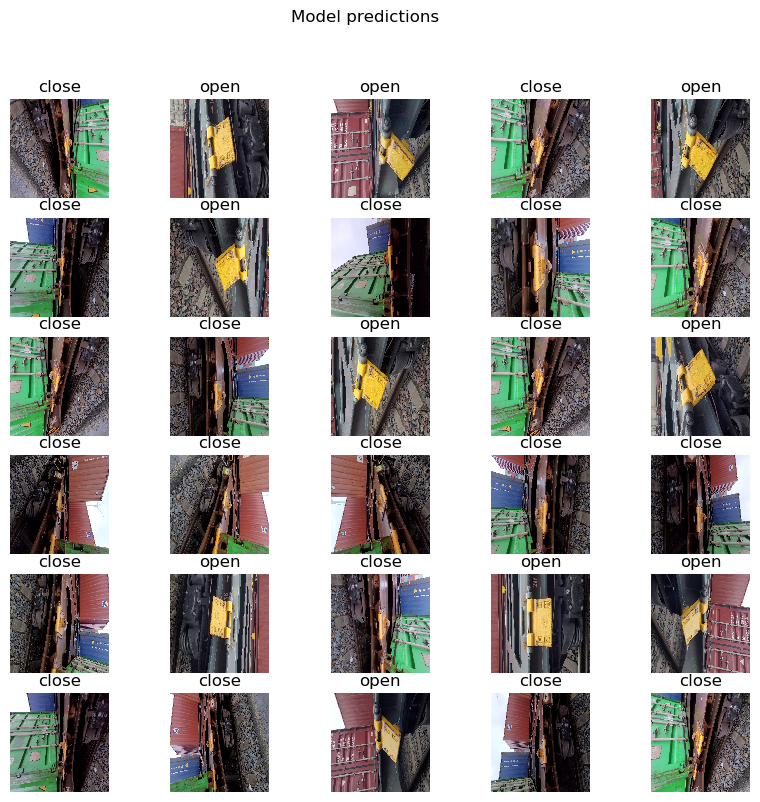

In [38]:
# 8- plot predictions
image_batch, _ = next(pin_classifier.val_data_gen)

label_batch = class_names

result_batch = model.predict(image_batch)

plt.figure(figsize=(10,9))
for n in range(30):
    plt.subplot(6,5,n+1)
    # plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n])
    plt.title(label_batch[np.argmax(np.array(result_batch[n]))])
    plt.axis('off')
_ = plt.suptitle("Model predictions ")